# Descarga y Exploracion de datos


## Descargar de los Ficheros
Vamos a realizar la descargas de los topics 'Toys and Games'

In [54]:
#Instalamos las librerías a utilizar que no están por defecto en colab
!pip install wget

In [121]:
#Importamos las librerias utilizadas
import pandas as pd
import wget
import gzip
import matplotlib.pyplot as plt
from collections import Counter
from nltk import ngrams
from nltk.probability import FreqDist
from wordcloud import WordCloud
import numpy as np
from sklearn.utils import shuffle
from sklearn.manifold import TSNE

In [56]:
#Descargamos los datos a utilizar
wget.download('http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Toys_and_Games_5.json.gz', './')

'.//reviews_Toys_and_Games_5.json (1).gz'

In [57]:
#Descomprimimos los datos
toys_json = gzip.open('reviews_Toys_and_Games_5.json.gz', 'rb')


In [58]:
#Creamos data Frames con los datos
data = pd.read_json(toys_json.read(), lines = True)

In [59]:
#Revisamos los datos
data

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1VXOAVRGKGEAK,0439893577,Angie,"[0, 0]",I like the item pricing. My granddaughter want...,5,Magnetic board,1390953600,"01 29, 2014"
1,A8R62G708TSCM,0439893577,Candace,"[1, 1]",Love the magnet easel... great for moving to d...,4,it works pretty good for moving to different a...,1395964800,"03 28, 2014"
2,A21KH420DK0ICA,0439893577,capemaychristy,"[1, 1]",Both sides are magnetic. A real plus when you...,5,love this!,1359331200,"01 28, 2013"
3,AR29QK6HPFYZ4,0439893577,dcrm,"[0, 0]",Bought one a few years ago for my daughter and...,5,Daughters love it,1391817600,"02 8, 2014"
4,ACCH8EOML6FN5,0439893577,DoyZ,"[1, 1]",I have a stainless steel refrigerator therefor...,4,Great to have so he can play with his alphabet...,1399248000,"05 5, 2014"
...,...,...,...,...,...,...,...,...,...
167592,A18Q24BZK2CB5P,B00LBI9BKA,nicole todhunter,"[0, 0]",This drone is very fun and super duarable. Its...,5,Very fun,1404691200,"07 7, 2014"
167593,A1I8ON1X0B2N2W,B00LBI9BKA,PF,"[1, 1]",This is my brother's most prized toy. It's ext...,5,Coolest toy on the market,1404691200,"07 7, 2014"
167594,A3V24H5350ULKI,B00LBI9BKA,Sara Tafuri,"[0, 0]",This Panther Drone toy is awesome. I definitel...,5,A great idea for kids!,1404777600,"07 8, 2014"
167595,A1W2F1WI0QZ4AJ,B00LBI9BKA,Tabitha Nicole,"[0, 0]",This is my first drone and it has proven to be...,5,Excellent Drone,1405641600,"07 18, 2014"


In [60]:
#Para este estudio solo vamos a utilizar reviewText y overall
data = data[['reviewText', 'overall']]
data.columns = ['Comentario', 'Valoracion']

In [61]:
data.head(10)

,Comentario,Valoracion
0,I like the item pricing. My granddaughter want...,5
1,Love the magnet easel... great for moving to d...,4
2,Both sides are magnetic. A real plus when you...,5
3,Bought one a few years ago for my daughter and...,5
4,I have a stainless steel refrigerator therefor...,4
5,this is a nice magnetic board for the kids to ...,3
6,This is just as I expected. It's not too sturd...,3
7,My granddaughter really really likes this. I l...,5
8,This is good product to have with unlimited po...,4
9,I keep this board on top of the hallway table ...,3


In [62]:
#Comprobamos que no tenemos datos nulos
print('Datos nulos en comentarios:', data.Comentario.isnull().sum())
print('Datos nulos en valoraciones:', data.Valoracion.isnull().sum())

Datos nulos en comentarios: 0
Datos nulos en valoraciones: 0


Incluimos una columna con la normalización del setimient0. En nuestro aplicación queremos que sea sensible al sentimiento positivo de un comentario por lo tanto normalizaremos en los 1, 2 y 3 como negativos (0) y 4 y 5 como positivo (1)

In [63]:
data['Sentiment'] = data['Valoracion'].apply(lambda x: 0 if x < 4 else 1)
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Comentario,Valoracion,Sentiment
0,I like the item pricing. My granddaughter want...,5,1
1,Love the magnet easel... great for moving to d...,4,1
2,Both sides are magnetic. A real plus when you...,5,1
3,Bought one a few years ago for my daughter and...,5,1
4,I have a stainless steel refrigerator therefor...,4,1
...,...,...,...
167592,This drone is very fun and super duarable. Its...,5,1
167593,This is my brother's most prized toy. It's ext...,5,1
167594,This Panther Drone toy is awesome. I definitel...,5,1
167595,This is my first drone and it has proven to be...,5,1


Por último para poder procesar realizar la práctica vamos a limitar a 10000 los registros a utilizar. Pero antes vamos a realizar un estudio de como están balceadas las valoraciones y el sentiment

(array([  4707.,      0.,   6298.,      0.,      0.,  16357.,      0.,
         37445.,      0., 102790.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

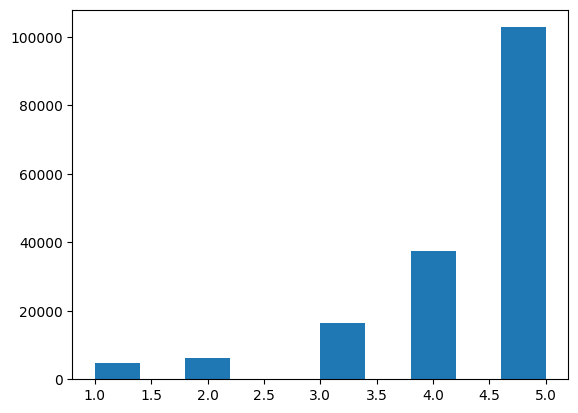

In [64]:
plt.hist(data.Valoracion.values, density = False)

(array([ 27362.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 140235.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

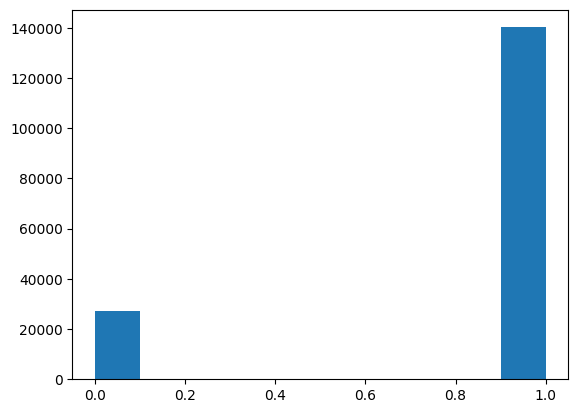

In [65]:
plt.hist(data.Sentiment.values, density = False)

Se puede apreciar que hay una gran diferencia entre valoraciones positivas y negativas, así que vamos a separar los data set en subset para diferenciar entre segun las valoraciones, y, así coger muestras aleatorias de ambos subconjuntos para equilibrar los comentarios entre positivos y negativos

In [66]:
data_1 = data[data['Valoracion']==1]
data_2 = data[data['Valoracion']==2]
data_3 = data[data['Valoracion']==3]
data_4 = data[data['Valoracion']==4]
data_5 = data[data['Valoracion']==5]

In [67]:
data_1 = data_1.sample(2000, random_state = 42)
data_2 = data_2.sample(2000, random_state = 42)
data_3 = data_3.sample(2000, random_state = 42)
data_4 = data_4.sample(3000, random_state = 42)
data_5 = data_5.sample(3000, random_state = 42)

data = shuffle(pd.concat([data_1, data_2, data_3, data_4, data_5])) #Contenamos y realizamos un shuffle para mezclar el muestreo estratificado
data.head(10)

,Comentario,Valoracion,Sentiment
164848,There isn't much to this set and although it l...,2,0
5130,This is often the game my kids pick when they ...,5,1
83939,These were a huge hit at our carnival themed b...,5,1
61318,My 3 yr old great-niece is in love. This is j...,5,1
134000,I got this for $20 cheaper on Amazon than at T...,3,0
3106,"When you paint with these, the colors barely s...",3,0
104932,Excellent Board. Easy to install and set up! ...,5,1
13999,If you play board games with someone who absol...,5,1
63904,I can't say I love this paper. Even though it ...,2,0
422,"This is a great game, lots of fun for many dif...",5,1


Repetimos los histogramas

(array([2000.,    0., 2000.,    0.,    0., 2000.,    0., 3000.,    0.,
        3000.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

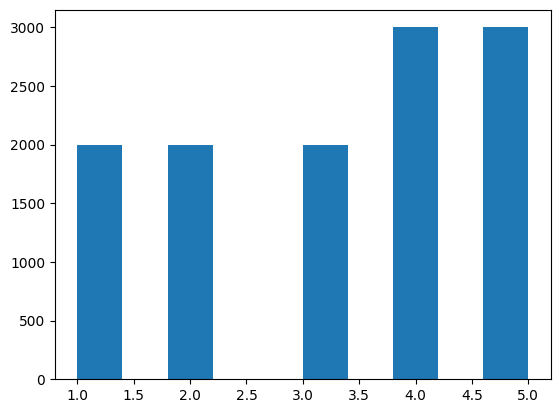

In [68]:
plt.hist(data.Valoracion.values, density = False)

(array([6000.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        6000.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

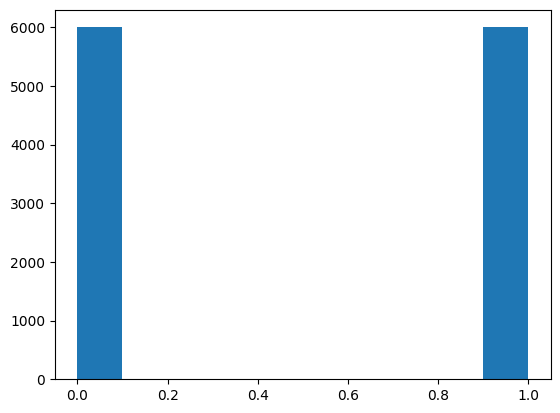

In [69]:
plt.hist(data.Sentiment.values, density = False)


Vemos que actualmente tenemos las cargas mejor balanceadas. Con este datset preparado vamos a comenzar con el Análisis Exploratorio y el posterior modelado vamos a guardar los datos

In [70]:
data.to_csv('./data.csv', sep = ',')

## Análisis Exploratorio
Vamos realizar un análisis exploratorio que contendrá las siguientes partes:


*   Cardinalidad el vocabulario
*   Distribución de reviews por número de estrellas (Realizado antes)
*   Número de reviews positivas y negativas (Realizado antes)
*   Top 10 Bigramas más frecuentes
*   Top 10 Trigramas más frecuentes
*   Visualización 2 dimensiones de word embeddigns



### Cardinalidad del vocabulario

In [71]:
text = data['Comentario'].values

In [72]:
corpus = []
for sentence in text:
  words = sentence.lower().split()
  for word in words:
    corpus.append(word)

In [73]:
corpus[:10]

['there',
 "isn't",
 'much',
 'to',
 'this',
 'set',
 'and',
 'although',
 'it',
 'looks']

In [74]:
len(corpus)

1330218

Si queremos ver valores únicos podemos realizar algo similar pero con un set

In [75]:
corpus_set = set()
for sentence in text:
  words = sentence.lower().split()
  for word in words:
    corpus_set.add(word)

In [76]:
corpus_set

{'bottoms.',
 '&#34;yellow,',
 'fridge.',
 'over-priced',
 'loves,',
 "'is'",
 "'realistic'",
 'dutch',
 'paucity',
 'mommy".',
 'mark-ups,',
 'wrong,',
 'playing.also,',
 '40k',
 'waterworks)',
 'tone.',
 'dracula',
 'pounds!',
 'passible',
 'insane.',
 '&#34;camera&#34;',
 'unnecessary,',
 '13-15',
 'drag.',
 'mack',
 'pegboards',
 '31',
 'review.of',
 'wig.-only',
 'design).i',
 'layed',
 'snip',
 'wisk',
 'usable,',
 'hollering,',
 'claus,',
 'ago.i',
 'ivisor',
 'congested',
 'announced',
 'inserted)',
 'upholstery',
 'voltages',
 'deadly,',
 'swims',
 'cred.',
 'so.2)',
 'are.we',
 'rippersmore',
 'places..it',
 'tooverall,',
 'doughboy-like',
 '$11',
 'arms...enhh...but',
 'all,',
 'creature,',
 'shut,',
 'mid-drawing',
 "percy's",
 'warned).',
 'buttons!',
 'flimslyoverall:',
 'argues',
 'lucky,',
 '"green."',
 'i,',
 'drama',
 'noticeable,',
 'losing,',
 'consequently',
 'around.but',
 'nothern',
 'universe/justice',
 '11).',
 'engine/compartments',
 'compose',
 'turns.',
 "th

In [77]:
len(corpus_set)

67241

Aqui podemos observar que existe cantidad de errores que aumenta la variabilidad de nuestro corpus para el preprocesamiento lo tendremos encuenta para limipiar nuestro corpus

In [78]:
vocabulary = Counter(corpus)

In [79]:
vocabulary.most_common(15)

[('the', 69783),
 ('and', 37815),
 ('to', 35632),
 ('a', 33933),
 ('it', 28018),
 ('i', 24164),
 ('is', 22344),
 ('of', 21394),
 ('this', 19168),
 ('for', 18306),
 ('that', 13933),
 ('with', 13748),
 ('my', 12970),
 ('in', 12451),
 ('but', 10828)]

Por último viendo la repetición de las palabras podemos ver que existen stop words que trataremos en el preprocesiamiento

###Top 10 Bigramas más frecuentes


In [80]:
bigrams = ngrams(corpus, 2)

In [81]:
bi_freq = FreqDist(bigrams)

In [82]:
bi_freq.most_common(10)

[(('of', 'the'), 5962),
 (('in', 'the'), 3713),
 (('is', 'a'), 3403),
 (('it', 'is'), 3252),
 (('on', 'the'), 3167),
 (('and', 'the'), 2707),
 (('with', 'the'), 2506),
 (('this', 'is'), 2483),
 (('for', 'the'), 2238),
 (('to', 'the'), 2203)]

In [83]:
bis_ = [str(bi[0]) for bi in bi_freq.most_common(10)]
bis_f_ = [bi[1] for bi in bi_freq.most_common(10)]

In [84]:
bis_f_, bis_ = zip(*sorted(zip(bis_f_, bis_)))

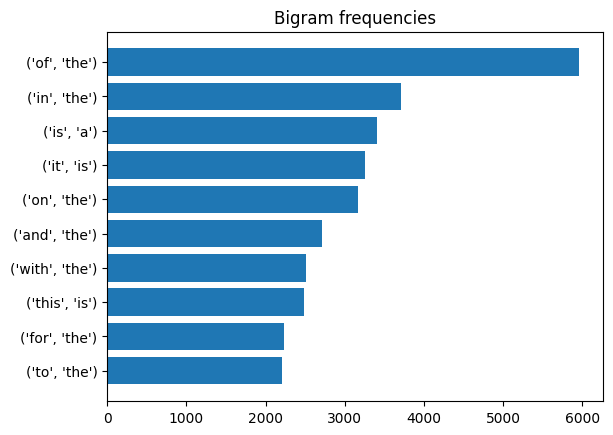

In [85]:
#Pintamos el gráfico de frecuencias de los Bigramas
plt.barh(bis_, bis_f_)
plt.title('Bigram frequencies')
plt.show()

###Top 10 Trigramas más frecuentes


In [86]:
trigrams = ngrams(corpus, 3)
tri_freq = FreqDist(trigrams)
tri_freq.most_common(10)

[(('this', 'is', 'a'), 1004),
 (('a', 'lot', 'of'), 849),
 (('to', 'play', 'with'), 554),
 (('out', 'of', 'the'), 528),
 (('this', 'for', 'my'), 518),
 (('i', 'bought', 'this'), 512),
 (('it', 'is', 'a'), 505),
 (('one', 'of', 'the'), 460),
 (('you', 'have', 'to'), 444),
 (('some', 'of', 'the'), 397)]

In [87]:
tri_ = [str(tri[0]) for tri in tri_freq.most_common(10)]
tri_f_ = [tri[1] for tri in tri_freq.most_common(10)]
tri_f_, tri_ = zip(*sorted(zip(tri_f_, tri_)))

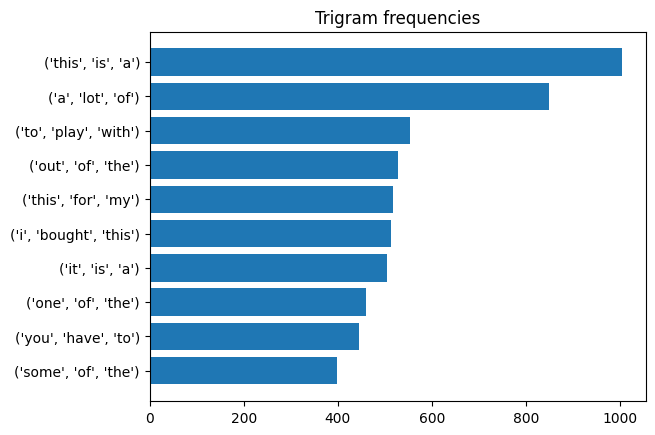

In [88]:
#Pintamos el gráfico de frecuencias de los Trigramas
plt.barh(tri_, tri_f_)
plt.title('Trigram frequencies')
plt.show()

### Word-Cloud

In [89]:
def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(text))
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

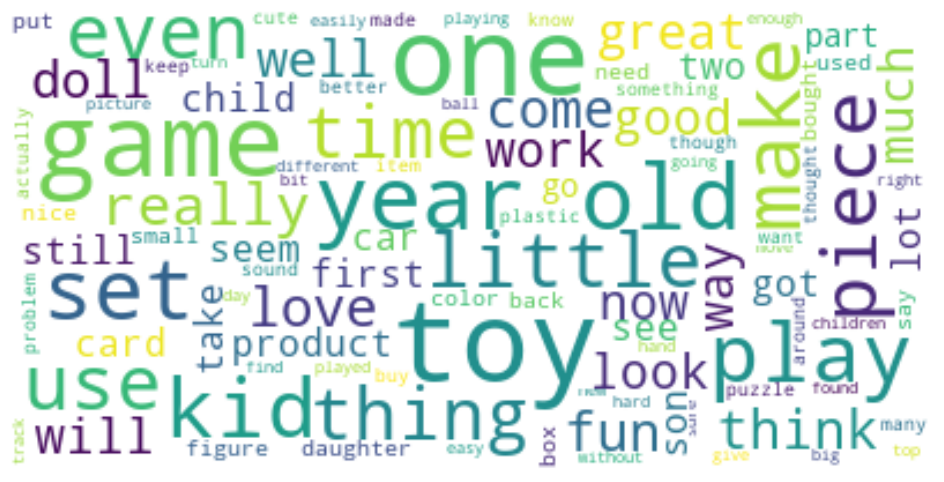

In [90]:
plot_word_cloud(corpus)

Podemos observar que se ven palabras repetidas de games, play, puzzle, relacionados con la tematica y otras palabras como good, great o love relacionado el sentimientos con un alto nivel de concurrencia

### Dispersión Lexica

In [91]:
from nltk.draw.dispersion import dispersion_plot

In [92]:
texts = list(data['Comentario'].values)
words = [word.lower() for text in texts for word in text.split()]

In [93]:
 target_words = [
    'game',
    'play',
    'toy',
    'piece',
    'kid'
]

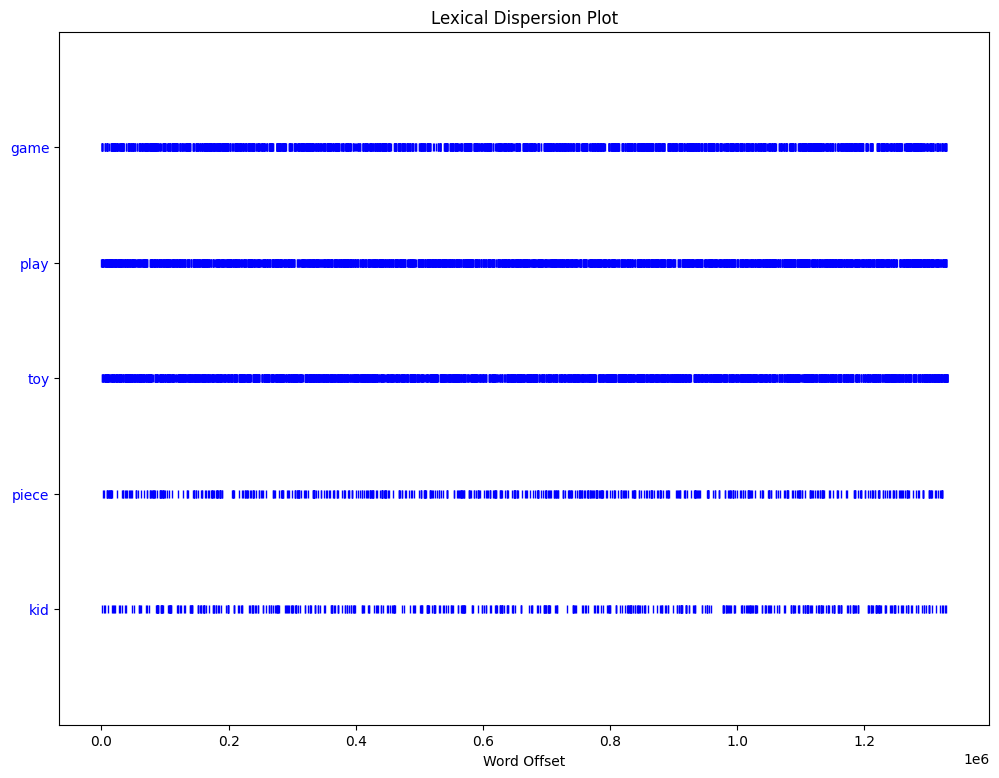

In [94]:
plt.figure(figsize=(12, 9))
plt.style.use('default')
dispersion_plot(words, target_words, ignore_case=True)
plt.show()

Al igual que en el word cloud podemos ver la alta concurrencia de estas palabras

### Word2Vec
Utilizaremos una aproximación Skip-grams para crear el word2Vec, puesto que tiene mejor resultado con corpus reducidos

In [95]:
from gensim.models import Word2Vec
import matplotlib.cm as cm

In [96]:
params = {
    'sg': 1,
    'size': 300,
    'min_count': 5,
    'window': 5,
    'hs': 0,
    'negative': 20,
    'workers': 4
}

In [111]:
texts = data['Comentario'].str.split()

In [112]:
w2 = Word2Vec(**params)

In [113]:
w2.build_vocab(texts)


In [117]:
w2.train(sentences=texts, total_examples=w2.corpus_count, epochs=20) 

(18799841, 26604360)

In [118]:
#Creamos los cluster
keys = ['game', 'play', 'toy', 'piece', 'kid']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(w2.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':


In [122]:
tsne_model_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32) 

In [123]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

In [124]:
embeddings_2d = np.array(tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2) 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


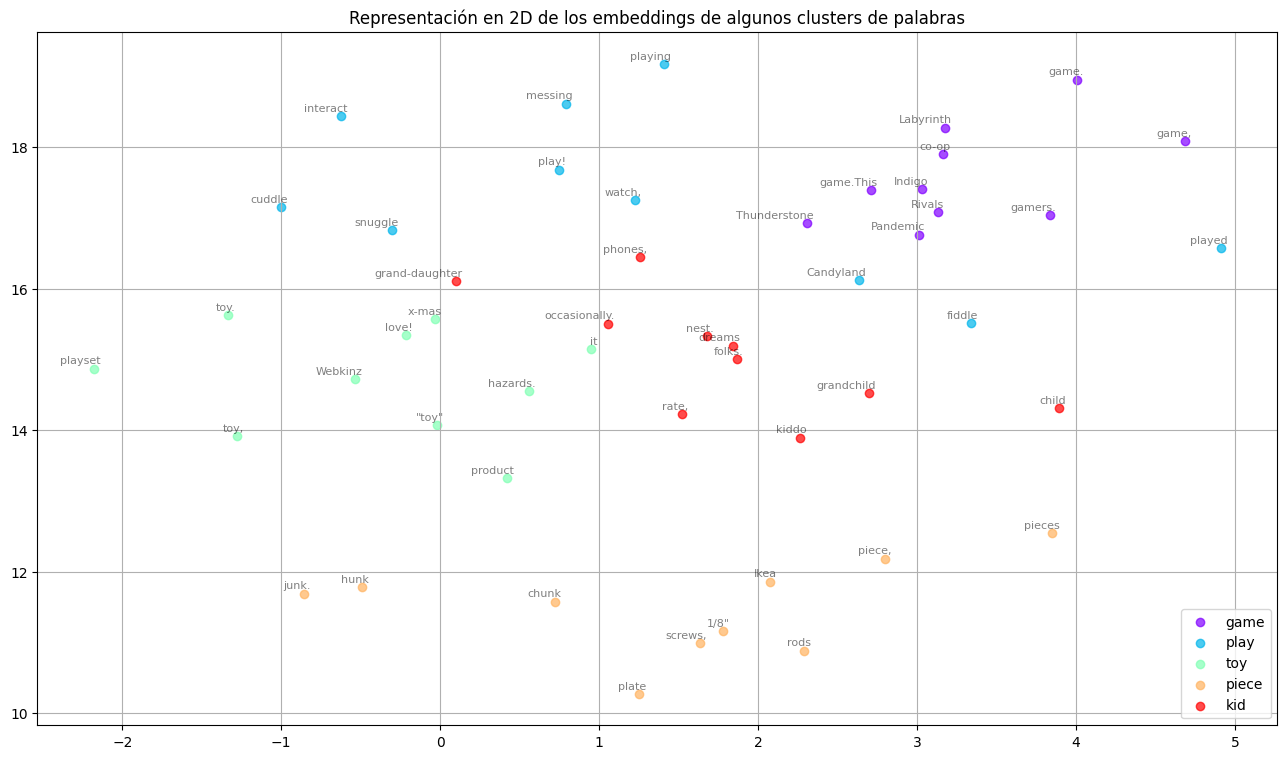

In [126]:
def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2), 
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.title('Representación en 2D de los embeddings de algunos clusters de palabras')
    # plt.savefig("f/г.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()

tsne_plot_similar_words(keys, embeddings_2d, word_clusters) 



Hay cinco cluster bastante diferenciados en el data set, pero vamos a probar con 4 para ver si la diferencia es mayor, para ellos eliminaremos play

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


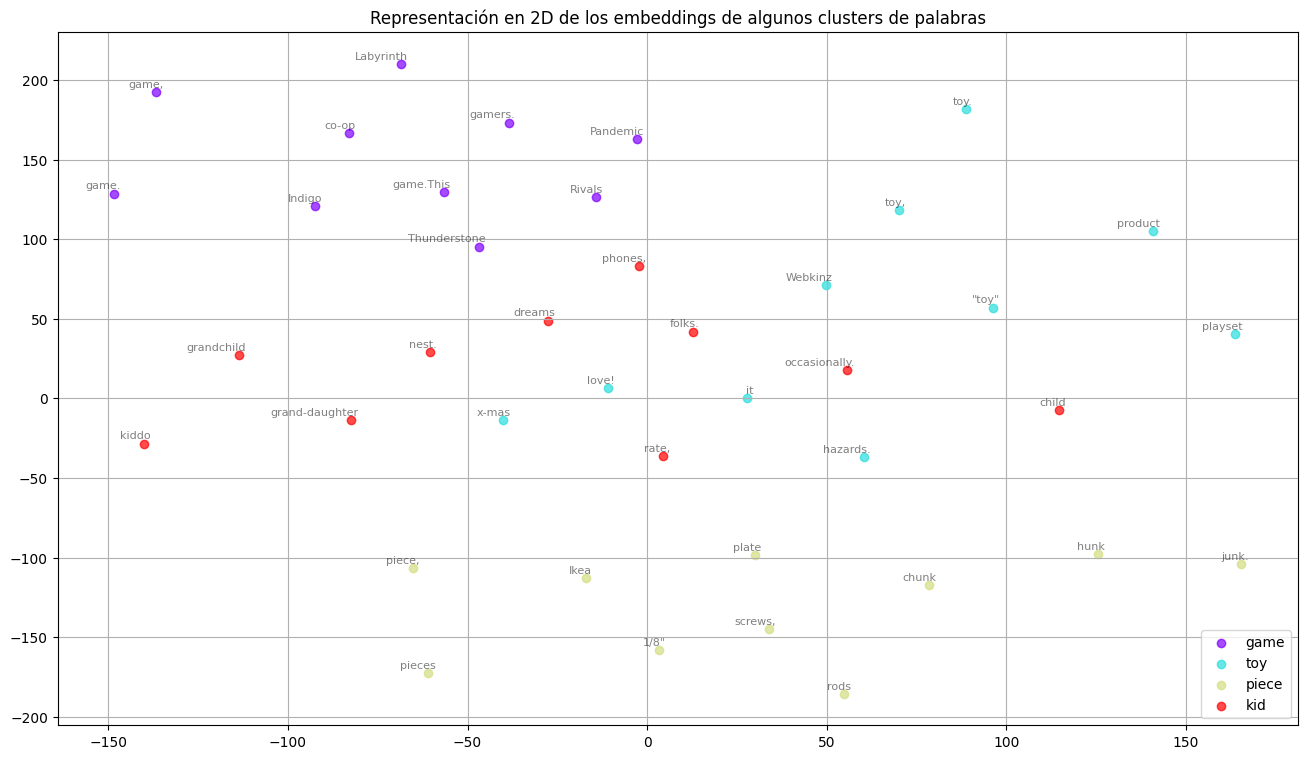

In [127]:
#Reducimos a 4
keys = ['game', 'toy', 'piece', 'kid']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(w2.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

embeddings_2d = np.array(tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2) 

tsne_plot_similar_words(keys, embeddings_2d, word_clusters) 

"Game" y "Piece" crean un dos grupos claramente separados del resto y toy and kidm aunque se aprecian dos cluster, pero con limites más difusos.

### Conclusiones Análisis Exploratorio
1. Reducimos el número de muestras para poder trabajar en posteriores fases
2. Existen errores frecuentes en los datos y mucho ruido que deberemos eliminar
3. Hay gran cantidad de stopwords (que eliminaremos en el procesado con cautela porque puede afectar al analisis del sentimiento, por ejemplo, "not")
4. Reducir la variabilidad de una misma palabra por sus derivaciones, por ejemplo, "play" y "playing"